In [0]:
import tensorflow as tf
#from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import scipy
import logging
import matplotlib.pyplot as plt
#import os
from sklearn import preprocessing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_curve

In [0]:
#for train
def ori_get_data(df): #input pandas
    names  = df.columns
    n, p = df.shape
    u = []
    std = []
    index = [] #數值的column
    
    for i in range(p):
        if len(np.unique(df[names[i]])) > 2 :
            u.append(np.mean(df[names[i]],axis = 0))
            std.append(np.std(df[names[i]],axis = 0))
            index.append(i)
    return index,u,std

In [0]:
def scale_data(df,u,std,index):
    names  = df.columns
    for index_ in index:
        i = 0
        df[names[index_]] = (df[names[index_]]-u[i])/std[i]
        i = i+1
    return np.array(df)

In [0]:
def get_noisy_data(df): #input array
    n,p = df.shape
    k = n//3
    population  = np.arange(n)
    
    for i in range(p):
        if len(np.unique(df[:,0])) <= 2:
            index = np.random.choice(population,k)
            df[index,i] = (df[index,i] + 1) % 2
        else:
            df[:,i]= df[:,i]+ 0.55 * np.random.normal(0,1,(n,1)).reshape(n)

    return df

## 有用i郵箱的資料作訓練

In [8]:
from google.colab import files
uploaded = files.upload()

Saving ibox_mail_change.csv to ibox_mail_change.csv


In [9]:
df = pd.read_csv("ibox_mail_change.csv")
df.head()

,Unnamed: 0,ACC2,ACC5,ACC15,ACC21,ACC22,ACC23,ACC25,ACC32,ACC7_0,ACC7_1,ACC7_2,ACC7_3,ACC10_0,ACC10_1,ACC10_2,ACC12_ACC13_11,ACC12_ACC13_12,ACC12_ACC13_13,ACC12_ACC13_14,ACC12_ACC13_15,ACC12_ACC13_16,ACC12_ACC13_17,ACC12_ACC13_18,ACC12_ACC13_19,ACC12_ACC13_1V,ACC12_ACC13_21,ACC12_ACC13_22,ACC12_ACC13_23,ACC12_ACC13_24,ACC12_ACC13_31,ACC12_ACC13_32,ACC12_ACC13_33,ACC12_ACC13_34,ACC12_ACC13_35,ACC12_ACC13_36,ACC16_0,ACC16_1,ACC16_2,ACC16_3,...,ACC35_00,ACC35_02,ACC35_03,ACC35_04,ACC35_05,ACC35_06,ACC35_11,ACC35_12,ACC35_13,ACC35_14,ACC35_15,ACC35_16,ACC35_17,ACC35_18,ACC35_19,ACC35_21,ACC35_22,ACC35_23,ACC35_24,ACC35_31,ACC35_34,ACC35_41,ACC35_42,ACC35_43,ACC35_51,ACC35_52,ACC35_53,ACC35_54,ACC35_55,ACC35_56,ACC35_57,ACC35_61,ACC35_62,ACC35_63,ACC35_64,ACC35_65,ACC35_66,ACC35_67,ACC31_,diff_day_
0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3475,7.251076
1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,833,1.245799
2,2,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,569,2.164583
3,3,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,8374,27.190000
4,4,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,225,2.359745


In [10]:
df = df.drop("Unnamed: 0", axis=1)
df.head()

,ACC2,ACC5,ACC15,ACC21,ACC22,ACC23,ACC25,ACC32,ACC7_0,ACC7_1,ACC7_2,ACC7_3,ACC10_0,ACC10_1,ACC10_2,ACC12_ACC13_11,ACC12_ACC13_12,ACC12_ACC13_13,ACC12_ACC13_14,ACC12_ACC13_15,ACC12_ACC13_16,ACC12_ACC13_17,ACC12_ACC13_18,ACC12_ACC13_19,ACC12_ACC13_1V,ACC12_ACC13_21,ACC12_ACC13_22,ACC12_ACC13_23,ACC12_ACC13_24,ACC12_ACC13_31,ACC12_ACC13_32,ACC12_ACC13_33,ACC12_ACC13_34,ACC12_ACC13_35,ACC12_ACC13_36,ACC16_0,ACC16_1,ACC16_2,ACC16_3,ACC16_4,...,ACC35_00,ACC35_02,ACC35_03,ACC35_04,ACC35_05,ACC35_06,ACC35_11,ACC35_12,ACC35_13,ACC35_14,ACC35_15,ACC35_16,ACC35_17,ACC35_18,ACC35_19,ACC35_21,ACC35_22,ACC35_23,ACC35_24,ACC35_31,ACC35_34,ACC35_41,ACC35_42,ACC35_43,ACC35_51,ACC35_52,ACC35_53,ACC35_54,ACC35_55,ACC35_56,ACC35_57,ACC35_61,ACC35_62,ACC35_63,ACC35_64,ACC35_65,ACC35_66,ACC35_67,ACC31_,diff_day_
0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3475,7.251076
1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,833,1.245799
2,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,569,2.164583
3,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,8374,27.190000
4,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,225,2.359745


## 切割training data 和 validation data

In [0]:
train_df_1, val_df_1 = train_test_split(df, test_size=0.1, random_state=0)

## 算出train data的統計量

In [0]:
train_df_1 = train_df_1
u = ori_get_data(train_df_1)[1]
std = ori_get_data(train_df_1)[2]
index = ori_get_data(train_df_1)[0]

## train/validation data標準化

In [14]:
train_df_sc_1 = scale_data(train_df_1,u,std,index)
val_df_sc_1 = scale_data(val_df_1,u,std,index)
print(len(train_df_sc_1))
print(len(val_df_sc_1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


11475
1275


In [0]:
mb_size = 500   #batch_size
X_dim = train_df_sc_1.shape[1]

hg_dim = [200,100,50,100,200]
hd_dim = [200,150,50,25]
lr_g = 1e-6
lr_d = 1e-6
lambda_ = 0.4

## 開始訓練

W0618 05:42:33.867442 140153751037824 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Iter: 0; D_loss:0.74; G_loss: 0.2114; g_test_loss: 0.03221 ; g_test_curr_loss =1e+05
Iter: 1; D_loss:0.7624; G_loss: 0.2149; g_test_loss: 0.0324 ; g_test_curr_loss =1e+05
Iter: 2; D_loss:0.7552; G_loss: 0.2195; g_test_loss: 0.03262 ; g_test_curr_loss =0.03262
Iter: 3; D_loss:0.7721; G_loss: 0.2238; g_test_loss: 0.03279 ; g_test_curr_loss =0.03262


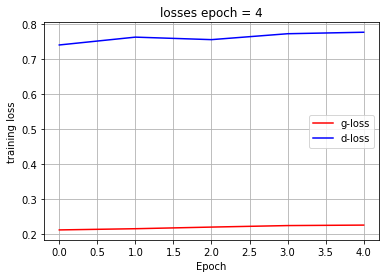

In [16]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)
  
def huber_loss(x, pre):
  return (abs(x)<=pre)*x**2/2 + (x>pre)*pre*(abs(x)-pre/2)

def lrelu(x, leak=0.2, name="lrelu"):
  return tf.maximum(x, leak*x, name=name)


X = tf.placeholder(tf.float32, shape=[None, X_dim])
z = tf.placeholder(tf.float32, shape=[None, X_dim])

D_W1 = tf.Variable(xavier_init([ X_dim, hd_dim[0]]))
D_b1 = tf.Variable(tf.zeros(shape=[hd_dim[0]]))
D_W2 = tf.Variable(xavier_init([ hd_dim[0], hd_dim[1]]))
D_b2 = tf.Variable(tf.zeros(shape=[hd_dim[1]]))
D_W3 = tf.Variable(xavier_init([ hd_dim[1], hd_dim[2]]))
D_b3 = tf.Variable(tf.zeros(shape=[hd_dim[2]]))
D_W4 = tf.Variable(xavier_init([ hd_dim[2], hd_dim[3]]))
D_b4 = tf.Variable(tf.zeros(shape=[hd_dim[3]]))
D_W5 = tf.Variable(xavier_init([ hd_dim[3], 1]))
D_b5 = tf.Variable(tf.zeros(shape=[1]))

G_W1 = tf.Variable(xavier_init([X_dim, hg_dim[0]]))
G_b1 = tf.Variable(tf.zeros(shape=[hg_dim[0]]))
G_W2 = tf.Variable(xavier_init([hg_dim[0], hg_dim[1]]))
G_b2 = tf.Variable(tf.zeros(shape=[hg_dim[1]]))
G_W3 = tf.Variable(xavier_init([hg_dim[1], hg_dim[2]]))
G_b3 = tf.Variable(tf.zeros(shape=[hg_dim[2]]))
G_W4 = tf.Variable(xavier_init([hg_dim[2], hg_dim[3]]))
G_b4 = tf.Variable(tf.zeros(shape=[hg_dim[3]]))
G_W5 = tf.Variable(xavier_init([hg_dim[3], hg_dim[4]]))
G_b5 = tf.Variable(tf.zeros(shape=[hg_dim[4]]))
G_W6 = tf.Variable(xavier_init([hg_dim[4], X_dim]))
G_b6 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_W3, G_W4, G_W5, G_W6, G_b1, G_b2, G_b3, G_b4, G_b5, G_b6]
theta_D = [D_W1, D_W2, D_W3, D_W4, D_W5, D_b1, D_b2, D_b3, D_b4, D_b5]


lossL1_d = tf.add_n([ tf.norm(D_W1) ]) * 0.0001
lossL2_g = tf.add_n([ tf.nn.l2_loss(v) for v in theta_G ]) * 0.0001

def get_noisy_data(df): #input array
    n,p = df.shape
    k = n//20
    population  = np.arange(n)
    
    for i in range(p):
        if len(np.unique(df[:,0])) <= 2:
            index = np.random.choice(population,k)
            df[index,i] = (df[index,i] + 1) % 2
        else:
            df[:,i]= df[:,i] + 0.05 * np.random.normal(0,1,(n,1)).reshape(n)

    return df

def generator(z):
    G_h1 = tf.nn.leaky_relu(tf.matmul(z, G_W1) + G_b1)
    G_h2 = tf.nn.leaky_relu(tf.matmul(G_h1, G_W2) + G_b2)
    G_h3 = tf.nn.leaky_relu(tf.matmul(G_h2, G_W3) + G_b3)
    G_h4 = tf.nn.leaky_relu(tf.matmul(G_h3, G_W4) + G_b4)
    G_h5 = tf.nn.leaky_relu(tf.matmul(G_h4, G_W5) + G_b5)

    G_log_prob = tf.matmul(G_h5, G_W6) + G_b6
    G_prob_cat = tf.nn.sigmoid(G_log_prob[:, :-2])
    G_prob = tf.concat([G_prob_cat,G_log_prob[:, -2:]], -1)
                     
    return G_prob


def discriminator(x):
    D_h1 = lrelu(tf.matmul(x, D_W1) + D_b1)

    D_h2 = lrelu(tf.matmul(D_h1, D_W2) + D_b2)
    D_h3 = lrelu(tf.matmul(D_h2, D_W3) + D_b3)
    D_h4 = lrelu(tf.matmul(D_h3, D_W4) + D_b4)
    out = tf.matmul(D_h4, D_W5) + D_b5
    
    return out


G_sample = generator(z)

D_real = discriminator(X)
D_fake = discriminator(G_sample)

#D_loss = tf.reduce_mean(tf.nn.l2_loss(tf.ones_like(D_real) - D_real) + tf.nn.l2_loss(tf.ones_like(D_fake) * (-1) - D_fake)) + lossL1_d
D_loss = tf.reduce_mean(tf.losses.huber_loss(tf.ones_like(D_real), D_real) + tf.losses.huber_loss(tf.ones_like(D_fake) * (-1), D_fake)) + lossL1_d


lr_loss = tf.reduce_mean((X - G_sample)**2)
G_loss = tf.losses.huber_loss(labels = tf.zeros_like(D_fake), predictions = D_fake) + lossL2_g

G_total_loss = lambda_ * lr_loss + G_loss

D_solver = (tf.train.AdamOptimizer(learning_rate=lr_d).minimize(D_loss, var_list=theta_D))
G_solver = (tf.train.AdamOptimizer(learning_rate=lr_g).minimize(G_total_loss, var_list=theta_G))

sess = tf.Session()
sess.run(tf.global_variables_initializer())


i = 0
D_loss_currs = []
G_loss_currs = []


pre_G_loss_curr = 0
pre_D_loss_curr = 0

g_test_curr_loss = 100000.
g_test_loss = 0.
X_test_batch = val_df_sc_1[: mb_size].astype(np.float32)
for it in range(100000):
    batch_idxs = len(train_df_sc_1) // mb_size
    
    for idx in range(0, batch_idxs):
        X_mb_batch = train_df_sc_1[idx * mb_size:(idx + 1) * mb_size]
        z_mb = get_noisy_data(X_mb_batch)
       
      
        while(1):
            _, D_loss_curr = sess.run( [D_solver, D_loss], feed_dict={X: X_mb_batch, z: z_mb})
            if (pre_D_loss_curr > D_loss_curr) and (pre_D_loss_curr - D_loss_curr < 1e-3):
              break
            pre_D_loss_curr = D_loss_curr

        while(1):
            _, G_loss_curr = sess.run( [G_solver, G_total_loss], feed_dict={X: X_mb_batch, z: z_mb})
            if (pre_G_loss_curr > G_loss_curr) and (pre_G_loss_curr - G_loss_curr < 1e-4):
              break
            pre_G_loss_curr = G_loss_curr

            
    g_test_loss = np.mean(huber_loss(X_test_batch, sess.run(generator(X_test_batch))))
    G_loss_currs.append(G_loss_curr)
    D_loss_currs.append(D_loss_curr)
    if it > 0 and it % 2 == 0:
      
      if (g_test_curr_loss - g_test_loss) < 0 :
        i = i+1
        if i == 1:
            plt.title('losses epoch = %s'%(it))
            plt.xlabel('Epoch')
            plt.ylabel('training loss')
            plt.grid()

            plt.plot(G_loss_currs,"r",label = 'g-loss')
            plt.plot(D_loss_currs,"b",label = 'd-loss')
            plt.legend()
            plt.savefig('plot_g_recon_losses_{}.png'.format(it))
            break
            
      g_test_curr_loss = g_test_loss
        
        
    
    print('Iter: {}; D_loss:{:.4}; G_loss: {:.4}; g_test_loss: {:.4} ; g_test_curr_loss ={:.4}'.format(it,D_loss_curr,G_loss_curr,g_test_loss,g_test_curr_loss))


## 帶入train_1檢測

In [17]:
predict_train = sess.run(discriminator(train_df_sc_1.astype(np.float32)))
predict_train

array([[-0.44518492],
       [ 0.11148699],
       [-0.09586467],
       ...,
       [ 0.24075824],
       [ 0.59472144],
       [ 0.59425443]], dtype=float32)

## 畫train_1的 score分佈圖

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


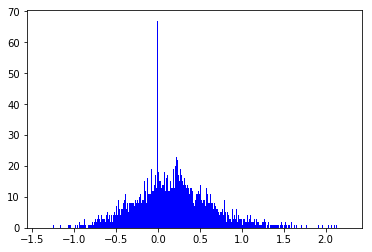

In [18]:
train_df_1["pre"] = predict_train
train_df_1["pre"] = round(train_df_1["pre"], 3)
plt.bar(pd.value_counts(train_df_1["pre"]).index, pd.value_counts(train_df_1["pre"]).values, color=['b'], width=0.005)
plt.show()

## 帶入validation_1檢測

In [19]:
predict_val = sess.run(discriminator(val_df_sc_1.astype(np.float32)))
predict_val

array([[ 0.3929927 ],
       [ 0.12873659],
       [-0.03947731],
       ...,
       [ 0.05705607],
       [ 0.31669444],
       [ 0.20855829]], dtype=float32)

## 畫validation_1 的 score分佈圖

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


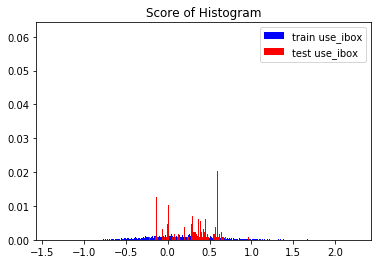

In [20]:
val_df_1["pre"] = predict_val
val_df_1["pre"] = round(val_df_1["pre"], 3)
plt.title('Score of Histogram')
plt.bar(pd.value_counts(train_df_1["pre"]).index, pd.value_counts(train_df_1["pre"]).values/len(train_df_1), color=['b'], width = 0.002,label = 'train use_ibox')
plt.bar(pd.value_counts(val_df_1["pre"]).index, pd.value_counts(val_df_1["pre"]).values/len(val_df_1), color=['r'], width = 0.002,label = 'test use_ibox')
plt.legend()
plt.show()

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
cnf_matrix = confusion_matrix(np.array(y), np.round(predict_0[1],0).T[0])

In [0]:
from itertools import cycle
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

## Plot ROC

In [0]:
fpr, tpr, thresholds = roc_curve(np.array(y), np.round(predict_0[1],0).T[0])
roc_auc = auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 散佈圖

In [0]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original.png")

### 有用i郵箱預測是否特約

In [0]:
sum(df['ACC2']==1)

## -----------------------------------------------

## testing data

In [0]:
import pandas as pd 
# data_reader = pd.read_csv("all_table_check_new.csv",engine='python', encoding='ANSI', chunksize=10000)
#初始化一个DataFrame
data_all = pd.DataFrame()
i = 0
for chunk in pd.read_csv("all_table_check_new.csv",engine='python', encoding='ANSI', chunksize=10000):
    chunk = chunk[chunk['ACC16_nan'] == 0 ]
    chunk = chunk[chunk['ACC24_nan'] == 0 ]
    chunk = chunk[chunk['ACC10_nan'] == 0 ]
    chunk = chunk[chunk['ACC7_nan'] == 0 ]
    chunk = chunk[chunk['ACC12_ACC13_nan'] == 0 ]
    chunk = chunk[chunk['ACC18_nan'] == 0 ]
    chunk = chunk[chunk['ACC24_nan'] == 0 ]
    chunk = chunk[chunk['ACC29_nan'] == 0 ]
    
    chunk['ACC35_00'] = chunk['ACC35_00'] + chunk['ACC35_nan'] 
    data_no = chunk.drop(['ACC19','ACC1','ACC17','ACC28','ACC7_nan','ACC36_F','ACC36_R','ACC36_nan','ACC16_nan','TT2',
              'ACC24_nan','y','ACC26_1','ACC26_2','ACC26_nan','ACC29_nan','ACC35_nan','ACC1','ACC10_nan','ACC12_ACC13_nan','ACC18_nan'], axis=1)
    data_no_i = scale_data(data_no,u,std,index)
    predict_no_y = sess.run(discriminator(data_no_i.astype(np.float32)))
    data_no['label'] = chunk['y']
    
    chunk['pre'] = predict_no_y
    chunk['pre'] = round(chunk['pre'],3)

    if i==0:
        chunk.to_csv('C:/Users/User/Desktop/all_table_noquot.csv', header=True, mode='a', index=0)

        i = i +1
    else:
        chunk.to_csv('C:/Users/User/Desktop/all_table_noquot.csv', header=False, mode='a', index=0)

In [0]:
import pandas as pd 
data_reader = pd.read_csv("all_table_noquot.csv", chunksize=100000, memory_map = True) 
#初始化一个DataFrame
data_all = pd.DataFrame()
i = 0
for chunk in data_reader:
    data_all = data_all.append(chunk)
    i = i +1
    if i==1:
        break
print(data_all.shape)

In [0]:
data_all = data_all[data_all['ACC16_nan'] == 0 ]
data_all = data_all[data_all['ACC24_nan'] == 0 ]
data_all = data_all[data_all['ACC10_nan'] == 0 ]
data_all = data_all[data_all['ACC7_nan'] == 0 ]
data_all = data_all[data_all['ACC12_ACC13_nan'] == 0 ]
data_all = data_all[data_all['ACC18_nan'] == 0 ]
data_all = data_all[data_all['ACC24_nan'] == 0 ]
data_all = data_all[data_all['ACC29_nan'] == 0 ]

In [0]:
data_all['ACC35_00'] = data_all['ACC35_00'] + data_all['ACC35_nan'] 
data_no = data_all.drop(['ACC19','ACC1','ACC17','ACC28','ACC7_nan','ACC36_F','ACC36_R','ACC36_nan','ACC16_nan','TT2',
              'ACC24_nan','y','ACC26_1','ACC26_2','ACC26_nan','ACC29_nan','ACC35_nan','ACC1','ACC10_nan','ACC12_ACC13_nan','ACC18_nan'], axis=1)
print(data_no.shape)


In [0]:
data_no_i = scale_data(data_no,u,std,index)

In [0]:
predict_no_y = sess.run(discriminator(data_no_i.astype(np.float32)))
sum(predict_no_y > 0)

In [0]:
data_no['label'] = data_all['y']

In [0]:
data_no['pre'] = predict_no_y
data_no['pre'] = round(data_no['pre'],3)
plt.bar(pd.value_counts(data_no["pre"]).index, pd.value_counts(data_no["pre"]).values/len(data_no), color=['b'], width=0.005)
plt.show()

## bar

In [0]:
df_test["pre"] = predict_all
df_test.head()

In [0]:
df_test_1 = df_test[df_test["y"]==1]
df_test_0 = df_test[df_test["y"]==0]

In [0]:
plt.bar(pd.value_counts(df_test_0["pre"]).index, pd.value_counts(df_test_0["pre"]).values, color=['b'], width=0.1)
plt.bar(pd.value_counts(df_test_1["pre"]).index, pd.value_counts(df_test_1["pre"]).values, color=['r'], width=0.4)
plt.show()

## f1_score 、 confusion_matrix

In [0]:
f1_score(data_no['label'], data_no['pre']>=-1, average='binary')

In [0]:
matrix = confusion_matrix(data_no['label'],data_no['pre'] >= 0)
matrix = matrix/len(data_no)

In [0]:
df_cm = pd.DataFrame(matrix)
df_cm.columns = ['score < 0','score > 0']
df_cm.index = ['use i-box','no use i-box']
df_cm

In [0]:
f, ax = plt.subplots(figsize = (5, 5))

cmap = sns.cubehelix_palette(start = 1, rot = 3, gamma=0.8, as_cmap = True)
sns.heatmap(df_cm, annot=True, cmap = cmap, linewidths = 0.05, ax = ax, annot_kws={'size':1})
ax.set_title('Amounts per kind and region')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)



In [0]:
import seaborn as sns
df_cm = pd.DataFrame(matrix)
sns.set(style="ticks")
sns.heatmap(df_cm)

In [0]:
df = pd.read_csv("all_table_noquot.csv")
df.head()